# Person - Exploratory Data Analysis

This Notebook is the basis for forecasting object counts given a date and hour. It contains 5 main sections:

- **Data load and definition**. Here we will compose the dataset and describe the features.
- **Data exploration and outlier analysis**. In this section we will start reviewing individual features and we decide if it is useful and if outliers are present.
- **Feature engineering**. Here we will create a few extra features which may be helpful to generate more accurate forecast.
- **Feature selection**. This task will help to decide which features are useful and influence the target variable.
- **Feature encoding**. It is necessary to encode certain features before the Machine Learning algorithms can be applied

In [2]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

TF -> Using GPU ->  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Data load and definition

The raw data extracted from the images is at the object level. Here are a few sample observations:

In [6]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4790, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


Analysis below will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minute intervals are definitely too random and 3 hours reduces the dataset size dramatically. Based on that it seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the `resampling` code snippet below.

In [7]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

# use Pandas handy resample feature to fill in gaps with 0's
resampled = df.set_index('date_time').resample('H')['dummy_var'].sum().reset_index()
resampled.columns = ['date_time', 'obs_count']
resampled['date'] = resampled['date_time'].dt.date.astype(str)
resampled['hour'] = resampled['date_time'].dt.hour
resampled = resampled[['date', 'hour', 'obs_count']]
resampled.head(2)

,date,hour,obs_count
0,2019-09-09,7,2
1,2019-09-09,8,3


Now we will strip the dates with the server or power outage

In [8]:
# remove any entries where we know that there was an error in measurements
orig_size = resampled.shape[0]
idx = resampled['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
resampled = resampled.loc[~idx]
print(f'Removed {orig_size - resampled.shape[0]} records')

Removed 72 records


### Discuss approach

Even though the dataset above looks very simple, we can not forget how difficult it was to collect it and prepare for further processing.

Based on the date column alone we can extract some interesting features, like:
- month
- week number
- is it a weekend day

Then the idea is to connect it with the weather data extracted from the Dark Sky API.

Once all the features are prepared, we can save the dataset again and move on to another Notebook, where we will create a prediction model, which will predict an object count for a given date and weather situation.

In [4]:
# add date-time related features
object_detections['date'] = pd.to_datetime(object_detections['date'])
object_detections['n_month'] = object_detections['date'].dt.month
object_detections['n_week_in_month'] = (object_detections['date'].dt.day-1)//7+1
object_detections['day_of_week'] = object_detections['date'].dt.dayofweek
object_detections['day_of_week_name'] = object_detections['date'].dt.weekday_name
object_detections['is_weekend_day'] = ((object_detections['date'].dt.dayofweek) // 5 == 1).astype(int)
object_detections.head(2)

,date,hour,obs_count,obs_count_corr,n_month,n_week_in_month,day_of_week,day_of_week_name,is_weekend_day
0,2019-09-09,7,2,2,9,2,0,Monday,0
1,2019-09-09,8,3,3,9,2,0,Monday,0


In [32]:
# based on the week name, define a new feature:
# WeekDay / Saturday / Sunday
object_detections['day_of_week_name_short'] = 'WeekDay'
idx = object_detections['day_of_week_name'].isin(['Saturday', 'Sunday'])
object_detections.loc[idx, 'day_of_week_name_short'] = object_detections[idx]['day_of_week_name']

### Warning

We are bringing-in here the actual weather data.

We need to be careful here, as when system runs in *Production*, it will use the weather forecast (not actuals), which can be wrong.

This variability can be costly and needs special attention down the line.

In [33]:
# load weather data
weather = pd.read_csv('../Datasets/dark_sky_data_2019-09-09_2020-03-02.csv')
weather.head(2)

,ts,dt,cur__summary,cur__precipIntensity,cur__precipProbability,cur__precipType,cur__temperature,cur__apparentTemperature,cur__humidity,cur__windSpeed,cur__windGust,cur__windBearing,cur__cloudCover,cur__uvIndex,cur__visibility,daily__summary,daily__sunriseTime,daily__sunsetTime,daily__temperatureHigh,daily__temperatureLow
0,1567985400,2019-09-09 00:30:00,Possible Light Rain,0.7929,0.47,rain,14.06,14.08,0.96,21.30,35.13,241,0.99,0,10.796,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01
1,1567989000,2019-09-09 01:30:00,Possible Light Rain,0.8310,0.45,rain,13.99,13.99,0.93,22.49,35.87,215,0.96,0,10.945,Possible drizzle in the morning.,1568008740,1568055900,16.6,7.01


In [34]:
# add date-time related features, so we can merge the datasets together
weather['dt'] = pd.to_datetime(weather['dt'])
weather['date'] = weather['dt'].dt.date
weather['date'] = pd.to_datetime(weather['date'])
weather['hour'] = weather['dt'].dt.hour
check_cols = ['dt', 'date', 'hour']
weather[check_cols].head(2)

,dt,date,hour
0,2019-09-09 00:30:00,2019-09-09,0
1,2019-09-09 01:30:00,2019-09-09,1


In [35]:
# join detections and weather data
merged = object_detections.merge(weather, on=['date', 'hour'])

In [36]:
# make sure that we have not lost any observations
assert object_detections.shape[0] == merged.shape[0]

### Feature analysis & engineering

- *is_weekend_day*

We can see in the plot below that during the weekend hours, people tend to sleep longer.

Then the activity becomes much more visible during the latest hours and it eventually sunsets at around 7PM on average.

The difference observed below proves that *is_weekend_day* should be considered as a good feature in the modelling stage.

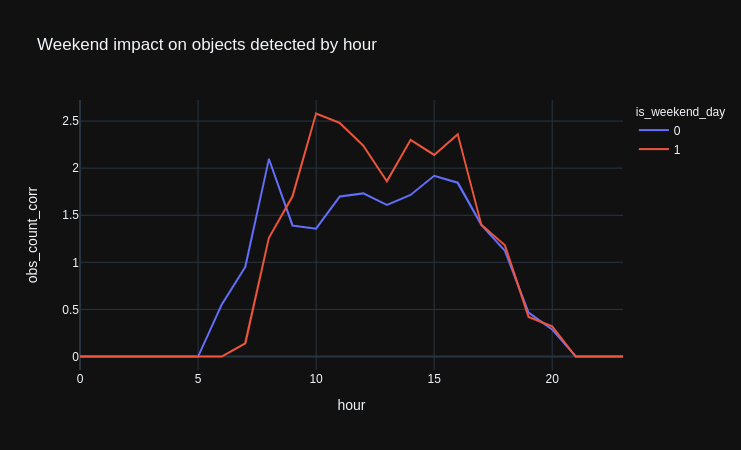

In [57]:
grouped = merged.groupby(['hour', 'is_weekend_day'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="is_weekend_day",
             title='Weekend impact on objects detected by hour')

- *cur__summary*

Does bad weather have an impact on the number of objects?

In [38]:
# define 3 categories of weather: Good, Bad and Perfect
merged['cur_weather_type'] = 'Good'
bad_weather_words = ['drizzle', 'rain', 'danger']
bad_idx = merged['cur__summary'].str.contains("|".join(bad_weather_words), case=False)
merged.loc[bad_idx, 'cur_weather_type'] = 'Bad'

As can be seen in the plot below, when weather is bad - the number of observations is the lowest.

Then, during a good weather, there is a visible increase in the activity.

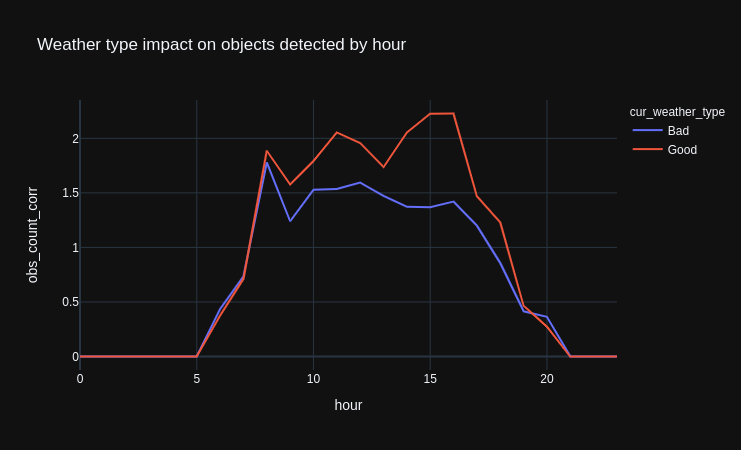

In [39]:
grouped = merged.groupby(['hour', 'cur_weather_type'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="cur_weather_type",
             title='Weather type impact on objects detected by hour')

- *cur__windGust*

Does gust speed affect the number of objects detected in the hourly time intervals?

Firstly we can plot the trend of gusts over time, and based on that we can decide on the threshold to break it down into categories, like Low and Strong.

Then we can see that for most of the time, Strong wind means less activity.

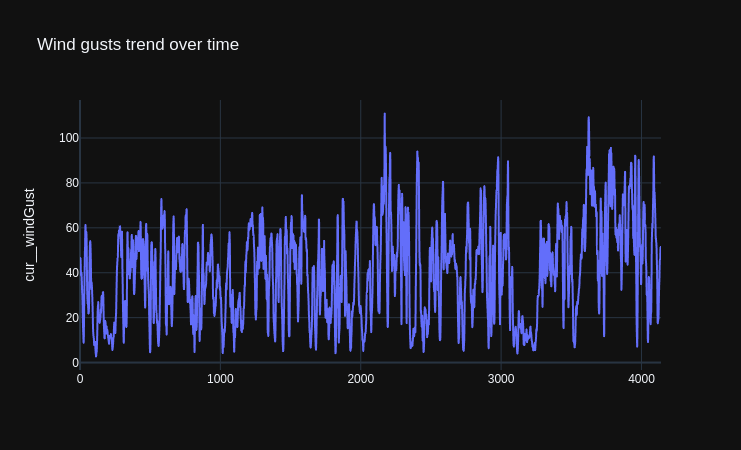

In [40]:
# take a look at the overall wind gust trend
grouped = merged.groupby(['date', 'hour'])['cur__windGust'].mean()
px.line(grouped, y="cur__windGust", height=300,
        title='Wind gusts trend over time')

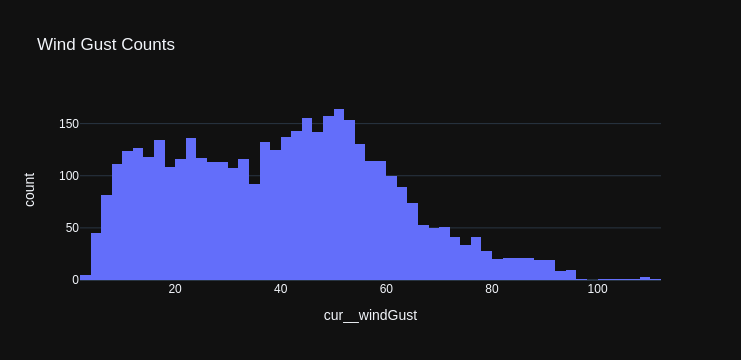

In [41]:
# now see the counts for each potential bucket
px.histogram(grouped, x="cur__windGust", height=300, nbins=100,
             width=600, title='Wind Gust Counts')

In [42]:
# define 2 categories of gusts: Normal and Strong
merged['wind_strength'] = 'Low'
idx = merged['cur__windGust'] >= 50
merged.loc[idx, 'wind_strength'] = 'Strong'

In [43]:
merged['wind_strength'].value_counts()

Low       2755
Strong    1385
Name: wind_strength, dtype: int64

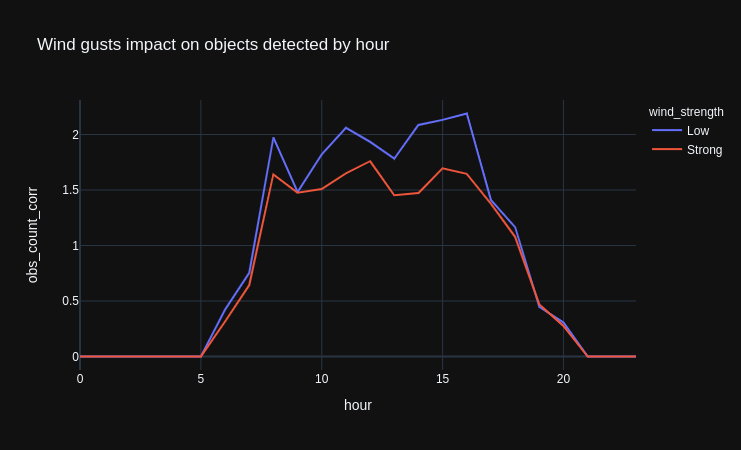

In [44]:
grouped = merged.groupby(['hour', 'wind_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="wind_strength", height=300,
        title='Wind gusts impact on objects detected by hour')

- *cur__precipIntensity*

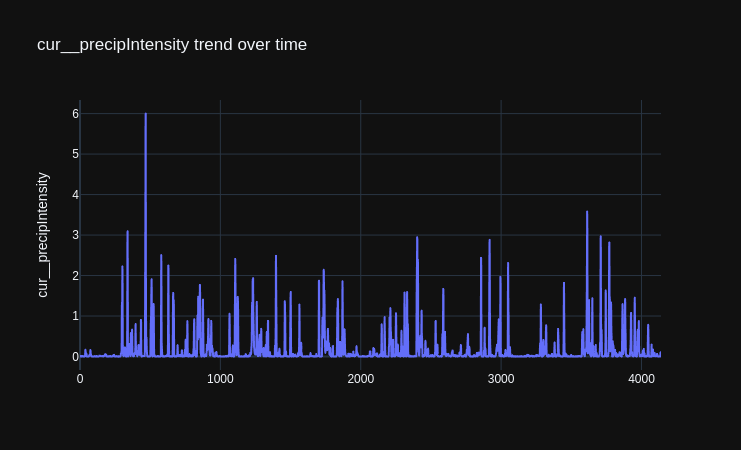

In [45]:
# take a look at the overall trend
grouped = merged.groupby(['date', 'hour'])['cur__precipIntensity'].mean().reset_index()
px.line(grouped, y="cur__precipIntensity", height=300,
        title='cur__precipIntensity trend over time')

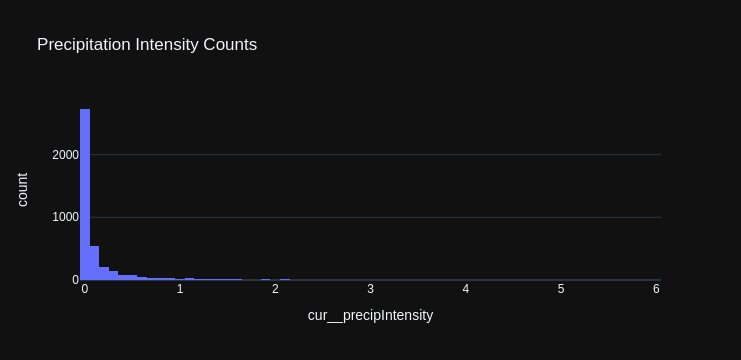

In [49]:
# now see the counts for each potential bucket
px.histogram(grouped, x="cur__precipIntensity", height=300, nbins=100,
             width=600, title='Precipitation Intensity Counts')

Looking at the trend we can see that there are rare events when precipitation is very high.

Breaking it down into 3 buckets confirms that it influences the count of observations.

In [50]:
# define 3 categories of gusts: Normal and Strong
merged['rain_strength'] = 'Low'
idx = merged['cur__precipIntensity'] > 0.1
merged.loc[idx, 'rain_strength'] = 'Higher'

In [51]:
merged['rain_strength'].value_counts()

Low       3093
Higher    1047
Name: rain_strength, dtype: int64

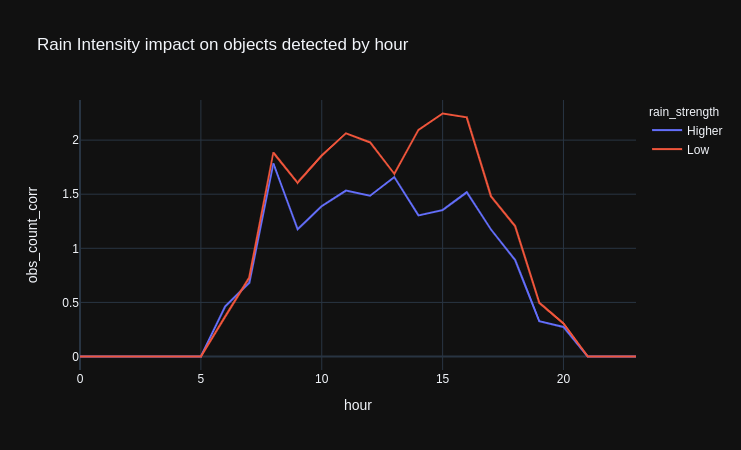

In [52]:
grouped = merged.groupby(['hour', 'rain_strength'])['obs_count_corr'].mean().reset_index()
px.line(grouped, y="obs_count_corr", x='hour', color="rain_strength", height=300,
        title='Rain Intensity impact on objects detected by hour')

## Feature encoding

### Numerical features:

Numerical features can be either directly fed into the Machine Learning algorithm, or they can be bucketed into categories based on the domain knowledge. We will use both approaches below.

### Categorical features:

Due to the fact that most of the ML algorithms can not deal with categorical features (like day of week or weather summary), they need to be somehow encoded as numbers. Below are the most common approaches currently used in the industry:

- for nominal encoding (when order does not matter)
    - one hot encoding
    - one hot encoding with many categories
    - mean encoding
- for ordinal encoding (when order matters)
    - label encoding
    - target guided ordinal encoding

### Group numerical features

Next, we can add all numerical columns as a separate dataframe

In [59]:
num_feat = ['is_weekend_day', 'cur__precipIntensity', 'cur__windSpeed', 'cur__windGust',
            'cur__cloudCover', 'cur__apparentTemperature', 'cur__precipProbability']
numerical = merged[num_feat]

### Encode categorical features

Features `cur_weather_type`, `wind_strength`, `rain_strength` and `day_of_week_name` can be treated as nominal for now, and we can encode them using one-hot-encoding technique.

One-hot-encoding takes all values from a feature and turns them into individual columns. A good practice here is to always drop one of the columns, as it can be derived based on other columns.

In [60]:
# One hot encode nominal categorical variables
nom_cat_features = ['cur_weather_type', 'wind_strength', 'rain_strength', 'day_of_week_name_short']
dummies = pd.get_dummies(merged[nom_cat_features], drop_first=False)
dummies.head(2)

,cur_weather_type_Bad,cur_weather_type_Good,wind_strength_Low,wind_strength_Strong,rain_strength_Higher,rain_strength_Low,day_of_week_name_short_Saturday,day_of_week_name_short_Sunday,day_of_week_name_short_WeekDay
0,0,1,1,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0,1


### Deal with cyclical features

How do we deal with features, like: `hour` or `week_number`? Even though they are numerical, they are not a typical numerical, ordinal values and they basically cycle through the time axis.

See this [Kaggle link](https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning) for more about this.

In [61]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)    

cycl_feat = ['hour', 'n_week_in_month', 'n_month']
cyclical = merged[cycl_feat].copy()
for col in cycl_feat:
    encode_cyclical(cyclical, col, cyclical[col].max())
    cyclical = cyclical.drop(columns=[col])

In [62]:
cyclical.head(2)

,hour_sin,hour_cos,n_week_in_month_sin,n_week_in_month_cos,n_month_sin,n_month_cos
0,0.942261,-0.33488,0.587785,-0.809017,-1.0,-1.836970e-16
1,0.816970,-0.57668,0.587785,-0.809017,-1.0,-1.836970e-16


### Output (target_ variable)

In [63]:
y = merged['obs_count_corr']

### Encode all selected features

Now, instead of merging all features inside a single dataframe, we can keep them as a tuple of individual dataframes and pickle that data structure.

This will make it easier to pick and choose features in the forecasting Notebook

In [64]:
ret_struct = ((numerical, dummies, cyclical, merged), y)
filename = 'Person_features__2019-09-09_2020-03-02.pickle'
outfile = open(f'../Datasets/{filename}','wb')
pickle.dump(ret_struct, outfile)
outfile.close()